In [1]:
library(tidyverse)
library(infer)

-- Attaching packages ------------------------------------------------------------------------------------------------------------------------------------------------------------------------ tidyverse 1.3.0 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.1.0     v dplyr   1.0.4
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts --------------------------------------------------------------------------------------------------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



# Vancouver Crime Data

## Introduction

## Preliminary Results

We'll start by importing the dataset from it's original source, loading it into a dataframe and inspecting the results.

In [2]:
download.file("http://geodash.vpd.ca/opendata/crimedata_download/crimedata_csv_all_years.zip", destfile="crime_data.zip")
unzip("crime_data.zip")
crime_data <- read_csv("crimedata_csv_all_years.csv")


-- Column specification -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
cols(
  TYPE = col_character(),
  YEAR = col_double(),
  MONTH = col_double(),
  DAY = col_double(),
  HOUR = col_double(),
  MINUTE = col_double(),
  HUNDRED_BLOCK = col_character(),
  NEIGHBOURHOOD = col_character(),
  X = col_double(),
  Y = col_double()
)




In [3]:
head(crime_data)

TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
Break and Enter Commercial,2012,12,14,8,52,NA,Oakridge,491285.0,5453433
Break and Enter Commercial,2019,3,7,2,6,10XX SITKA SQ,Fairview,490613.0,5457110
Break and Enter Commercial,2019,8,27,4,12,10XX ALBERNI ST,West End,491007.8,5459174
Break and Enter Commercial,2014,8,8,5,13,10XX ALBERNI ST,West End,491015.9,5459166
Break and Enter Commercial,2020,7,28,19,12,10XX ALBERNI ST,West End,491015.9,5459166
Break and Enter Commercial,2005,11,14,3,9,10XX ALBERNI ST,West End,491021.4,5459161


We're primarily interested in the year, type and neighbourhood of crimes, so we'll extract those columns and discard the rest. In addition, we would like to focus on year 2017-2020.

In [4]:
crime_data <- crime_data %>% 
    select(TYPE, YEAR, NEIGHBOURHOOD) %>%
    filter(2017 <= YEAR & YEAR <= 2020)
head(crime_data)

TYPE,YEAR,NEIGHBOURHOOD
<chr>,<dbl>,<chr>
Break and Enter Commercial,2019,Fairview
Break and Enter Commercial,2019,West End
Break and Enter Commercial,2020,West End
Break and Enter Commercial,2017,West End
Break and Enter Commercial,2018,West End
Break and Enter Commercial,2020,West End


Next, let's see how many different types of crimes there are.

In [5]:
unique(crime_data$TYPE)

[1] "Break and Enter Commercial"                            
 [2] "Break and Enter Residential/Other"                     
 [3] "Homicide"                                              
 [4] "Mischief"                                              
 [5] "Offence Against a Person"                              
 [6] "Other Theft"                                           
 [7] "Theft from Vehicle"                                    
 [8] "Theft of Bicycle"                                      
 [9] "Theft of Vehicle"                                      
[10] "Vehicle Collision or Pedestrian Struck (with Fatality)"
[11] "Vehicle Collision or Pedestrian Struck (with Injury)"

We're hoping to compare crime rates across years in neighbourhoods that represent a reasonable distribution of incomes. For our proposal, we're going to be using the Shaughnessy, Strathcona, and Marpole neighbourhoods.

In [6]:
crime_data <- crime_data %>%
    filter(NEIGHBOURHOOD %in% c("Shaughnessy", "Strathcona", "Marpole"))
head(crime_data)

TYPE,YEAR,NEIGHBOURHOOD
<chr>,<dbl>,<chr>
Break and Enter Commercial,2017,Strathcona
Break and Enter Commercial,2020,Strathcona
Break and Enter Commercial,2020,Strathcona
Break and Enter Commercial,2017,Strathcona
Break and Enter Commercial,2018,Strathcona
Break and Enter Commercial,2019,Strathcona


In [7]:
neighbourhood_year_counts <- crime_data %>% group_by(NEIGHBOURHOOD, YEAR) %>% summarise(number_of_crimes = n())

`summarise()` has grouped output by 'NEIGHBOURHOOD'. You can override using the `.groups` argument.



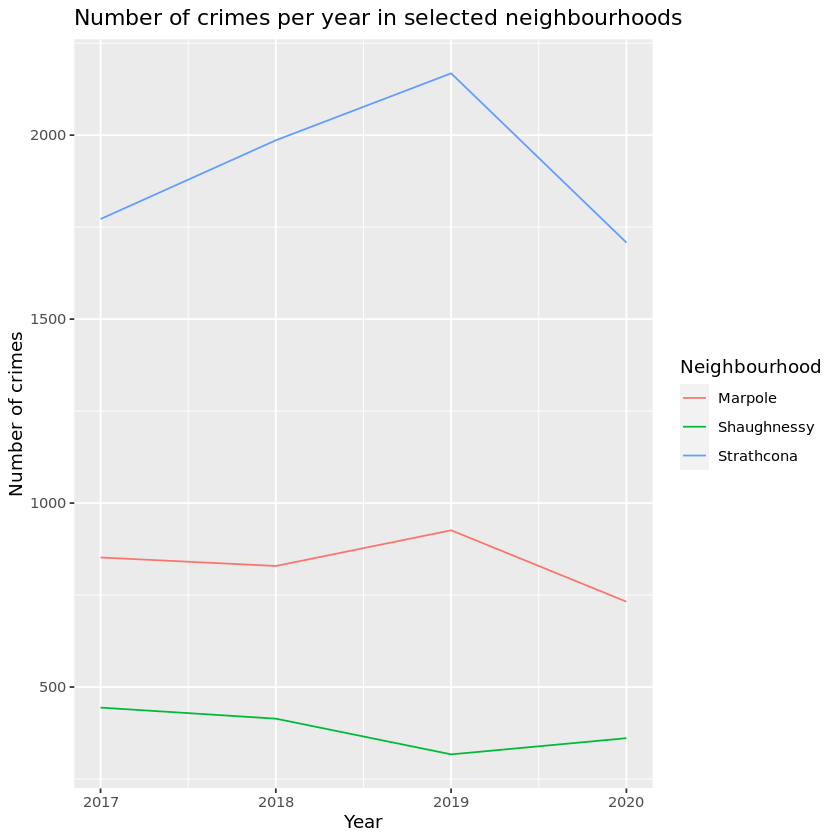

In [8]:
crime_data_plot <- neighbourhood_year_counts %>%
    ggplot() +
    geom_line(aes(x=YEAR, y=number_of_crimes, color=NEIGHBOURHOOD)) +
    xlab("Year") +
    ylab("Number of crimes") +
    labs(color="Neighbourhood") +
    ggtitle("Number of crimes per year in selected neighbourhoods")

crime_data_plot

## Methods/Plan

### The Data Set

We will retrieve Vancouver Police Force's crime data to use as our sample for reported crimes in Vancouver [6]/

The zip file from above contains a data set that has all crimes reported to the VPD.  

We have to consider that although the data set contains all the crimes reported to VPD, it does not represent all the crimes that occurred in Vancouver. The data set of reported crimes are a sample of all crimes that occurred in Vancouver, collected via people calling in to report that a crime has occurred. This means that there will be crimes that occurred, and were not reported to VPD since people might not consider petty crimes to be worth the time involving the police.  That might be an inherent bias for us, as we are looking at if petty crime increased during 2020.  

That said, those bias might be mitigated since we are analyzing if the proportion of thefts increased in 2020 compared to previous years.  
Since the proportion of thefts is calculated by (All reported thefts that occurred)/(All reported crimes), two ways might increase the proportion of thefts:

- More thefts are reported compared to the other crimes that are reported in 2020.
- Even as people report less crime, the amount of thefts that are reported is at least the same as in previous years.

This means that unless there are other unforeseen reasons of why people might change why they will report certain crimes and not others, as long as the ratio of reported thefts and actual thefts that occurred does not change (a parameter that we cannot observe), we can assume that more theft has to occur compared to other crimes for the proportion of reported thefts to increase.
We will retrieve Vancouver Police Force's crime data from the link below:
http://geodash.vpd.ca/opendata/crimedata_download/crimedata_csv_all_years.zip?disclaimer=on&x=101&y=21

The zip file from above contains a data set that has all crimes reported to the VPD.  

We have to conside that although the data set contains all the crimes reported to VPD, it does not represent all the crime that occured in Vancouver. Reported crime are a sample of all crimes occured in Vancouver, collected via people calling in to reported that a crime has occured. This means that there will be crimes that occured, and was not reported to VPD since people might not consider petty crimes to be worth the time involving the police.  That might be an inherient bias for us, as we are looking at if petty crime increased during 2020.  

That said, those bias might be mitigated since we are analyzing if the proportion of thefts increased in 2020 compared to previous years.  
Since proportion of thefts is calculated by (All reported thefts that occured)/(All reported crimes), there are two ways that might increase the proportion of thefts:

- The more thefts are reproted compared to the other crimes that are reported in 2020.
- Even as people report less crime, the amount of thefts that are reported is at least the same amount as previous years.

This means that unless there are other unforeseen reason of why people might change why they will report certain crimes and not other, as long as the ratio of reported thefts and actual thefts that occured does not change (an parameter that we cannot observe), we can assume that more theft has to occur compared to other crimes for the proprotion of reported thefts to increase.

### Plan

Inside the zip file, there is a CSV file call 'crimedata_csv_all_years.csv' with the following headers:


|   Header Name     | Description         |
|:------------------|:----------|
|YEAR            |A four-digit field that indicates the year when the reported crime activity occurred          |
|MONTH           |A numeric field that indicates the month when the reported crime activity occurred          |
|DAY             |A two-digit field that indicates the day of the month when the reported crime activity occurred         |
|HOUR            |A two-digit field that indicates the hour time (in 24 hours format) when the reported crime activity occurred         |
|MINUTE          |A two-digit field that indicates the minute when the reported crime activity occurred         |
|HUNDRED_BLOCK   |Generalized location of the report crime activity         |
|NEIGHBOURHOOD   |The Vancouver Police Department uses the Statistics Canada definition of neighbourhoods within municipalities. Neighbourhoods within the City of Vancouver are based on the census tract (CT) concept within census metropolitan area (CMA).          |
|X               |Coordinate values are projected in UTM Zone 10. All data must be considered offset and users should not interpret any locations as related to a specific person or specific property          |
|Y               |Coordinate values are projected in UTM Zone 10. All data must be considered offset and users should not interpret any locations as related to a specific person or specific property.          |

To narrow the scope of our project, we will focus on these neighbourhoods and run individual analysis on the crime rate of the following neighbourhoods:
To narrow the scope of our project, we will focus on these neighbourhoods and run individual analysis on the crime rate of those neighbourhood:

- Strathcona 
- West End
- Shaughnessy

As for right now, we will focus on Strathcona and have the other neighbourhood for further analysis.

We base our selection on the neighbourhood base on the 'Average total income in 2015 among recipient'(ID#1858) as reported in Census Local Area Profiles 2016 from the City of Vancouver[1].  The list above ranks the neighbourhood from the lowest average total income to the highest, with West End roughly at the median of all the neighbourhoods.

We will use hypothesis testing to see if the proportion of reported thefts increased compared to previous years.  
For our null hypothesis, we will be calculating the sampling mean proportion for 2017, 2018, and 2019 combined to eliminate outlying years while only using recent years to ensure that that the proportion of theft from the neighbourhood has not drastically changed due to factors such as gentrification or city revitalizations.  We will also report on the confidence interval of the sampling mean of those years, to ensure that there is not a large variance in the mean proportion.

We will be testing our null hypothesis against the bootstrap proportion of reported thefts that occurred in 2020.

### Impact and Further Questions

We hope that the result from our study can give actionable insights to city officials and the Vancouver Police Department.  While we can use anecdotal evidence to say that crimes have gone up because Vancouver feels more unsafe in 2020 compared to previous years, we want to use scientific evidence collected from our hypothesis testing to prove if Vancouver is more unsafe compare to the previous year.

This information can potentially lead to how the city might allocate resources when combating crime:  
- If the theft rate has increased, the city can look into finding ways to provide economic relief to those who are impacted or increase awareness of who to prevent theft
- If the theft rate has not increased, the city can explore other reason why Vancouver felt more unsafe in 2020 and put resources in preventing it in the future
As for right now, we will focus on Strathcona and have the other neighbourhood as further analysis.

We base our selection on of the neighbourhood base on the 'Average total income in 2015 among recipient'(ID#1858) as reported in Census Local Area Profiles 2016 from City of Vancouver[1].  The list above ranks the neighbourhood from the lowest average total income to the highest, with West End roughly at the median of all the neighbourhood.

We will use hypothesis testing to see if the proportion of reported thefts increased compared to previous years.  
For our null hypothesis, we will be calcualting the sampling mean proportion for 2017, 2018, and 2019 combined to eliminate outlying years while only using recent years to ensure that that the proportion of theft from the neighbourhood has not drastically change due to factors such as genrtification or city revitalizations.  We will also report on the confidence interval of the sampling mean of those years, to ensure that there is not a large variance in the mean proportion.

We will be testing our null hypothesis against the bootstrap proportion of reported thefts that occured in 2020.

### Impact and Further Questions

We hope that the result from our study can give actionable insights to city officals and the Vancouver Police Department.  While we can use anectodal evidence to say that crimes has gone up because that Vancouver feels more unsafe in 2020 compared to previous years, we want to use scientific evidence collected from our hypothesis testing to prove if Vancouver is more unsafe compare to previous year.

This information can potential lead to how the city might allocate resources when combating crime:  
- If theft has increase, the city can look into finding ways to provide economic relef to those who are impact, or increase awareness of who to prevent theft
- If theft has not increase, the city can explore other reason why Vanouver felt more unsafe in 2020 and put reasources in prevent it in the future





## References (WE STILL NEED TO FORMAT THIS USING MLA OR SMTH)

[1] https://opendata.vancouver.ca/explore/dataset/census-local-area-profiles-2016/information/
- City of Vancouver Census collected in 2015

[2] https://www.cbc.ca/news/canada/british-columbia/crime-statistics-vancouver-2020-1.5779400

[3] https://www.osac.gov/Country/Canada/Content/Detail/Report/fd184899-ac3b-4e43-a31b-18f82fda35c4

[4] https://bc.ctvnews.ca/hate-crimes-up-97-overall-in-vancouver-last-year-anti-asian-hate-crimes-up-717-1.5314307

[5] https://www.cbc.ca/news/canada/british-columbia/city-of-vancouver-freezes-police-department-funding-as-part-of-2021-budget-1.5833731

[6] http://geodash.vpd.ca/opendata/crimedata_download/crimedata_csv_all_years.zip?disclaimer=on&x=101&y=21
- location of our data set from the Vancouver Police Department